<br>

<h1 style="text-align: center;">Stable Diffusion using Keras-CV</h1>

<br>

## Initial Setup

---

In [5]:
# Import the libraries
import os
import warnings
warnings.filterwarnings("ignore")
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import cv2
from PIL import Image 
from textwrap import wrap
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow.keras import mixed_precision
from tensorflow import keras
from datasets import load_dataset
from PIL import Image


In [6]:
# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found")


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [7]:
# Enable GPU Growth: Sometimes TensorFlow allocates all GPU memory by default. To avoid this and allow TensorFlow to allocate only as much GPU memory as needed, you can enable memory growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
# Setup the auto mixed precison
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

<br>

## Load Dataset

---

In [9]:
# Base path
base_path = "./../input/gaming-asset-for-text-to-image-models/"

In [10]:
# Load the csv dataset
df = pd.read_csv(base_path + "dataset.csv")

# Add base pathxz to the image path
df["image"] = df["image"].apply(lambda x: os.path.join(base_path, "images", x))

# Display the first few rows of the DataFrame
df.head()


,image,caption
0,./../input/gaming-asset-for-text-to-image-mode...,a demonic demon with two large swords
1,./../input/gaming-asset-for-text-to-image-mode...,"a knight in purple, black and white with an el..."
2,./../input/gaming-asset-for-text-to-image-mode...,a warrior with a sword in hand
3,./../input/gaming-asset-for-text-to-image-mode...,an ancient lady holding two swords
4,./../input/gaming-asset-for-text-to-image-mode...,the faceless king holding a sword


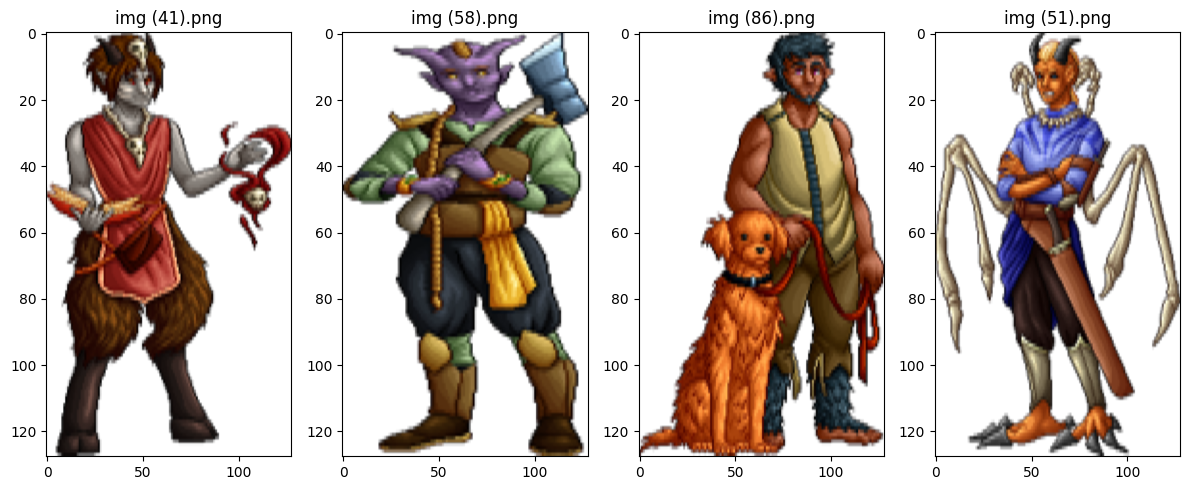

In [ ]:
# specify your path
data_dir = base_path + "images/"

# get all file names
image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

# create a figure to contain the plot.
fig = plt.figure(figsize=(12, 5))  # Increase the height here

# define a size
size = (50, 50)

# adjust subplot parameters
plt.subplots_adjust(hspace=0.05)

# load and display first few images
index = 10
for i, image_file in enumerate(image_files[index:index+4]):
    image_path = os.path.join(data_dir, image_file)
    image = Image.open(image_path)
    
    # resize image
    image = image.resize(size)
    
    # Add subplot.
    ax = fig.add_subplot(1, 4, i+1)  # Change the number of columns to match the number of images
    ax.imshow(image)
    
    # split title into multiple lines
    title = '\n'.join(image_file[i:i+30] for i in range(0, len(image_file), 30))
    ax.title.set_text(title)
    ax.set_aspect('auto')  # Set the aspect ratio of the images to 'auto'

plt.tight_layout()  # Adjust the layout so that the titles do not overlap
plt.show()

In [12]:
# # Create a dataframe with filenames and text
# df = pd.DataFrame(image_files, columns=['image'])
# df['text'] = df['image'].apply(lambda x: x.split('.')[0])

# # Add ./data to the image path
# df["image"] = df["image"].apply(lambda x: os.path.join(data_dir, x))

# df

In [13]:
# Take a sample
data = df.sample(40)
data.shape

(40, 2)

<br>

## Hyperparameters

---



In [13]:
# Hyperparameters
PADDING_TOKEN = 49400
MAX_PROMPT_LENGTH = 77
RESOLUTION = 128 # int(128 / 2)
batch_size = 1
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08
epochs = 1

<br>

## Data Processing

---

In [ ]:
# Constants
AUTO = tf.data.AUTOTUNE

# Load the tokenizer
tokenizer = SimpleTokenizer()  

# Function for tokenizing the text
def tokenize_text(text):
    """Tokenize and pad the given text."""
    tokens = tokenizer.encode(text.numpy())
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)

# Function for processing the image
def process_image(image, tokenized_text):
    """Process and resize images."""
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text

# Function for processing the text
def tf_process_text(text):
    """Wrap tokenize_text function for TensorFlow."""
    result = tf.py_function(tokenize_text, [text], tf.int32)
    result.set_shape((MAX_PROMPT_LENGTH,))
    return result

# Function for augmenting and encoding the data
def augment_and_encode(image_batch, token_batch):
    """Apply data augmentation to the image batch and encode text."""
    augmented_images = augmenter(image_batch)
    encoded_text = text_encoder([token_batch, POS_IDS], training=False)
    return {
        "images": augmented_images,
        "tokens": token_batch,
        "encoded_text": encoded_text,
    }

# Function for preparing the dataset
def prepare_dataset(image_paths, texts, batch_size=1):
    """Prepare the dataset from image paths and texts."""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(lambda x, y: (x, tf_process_text(y)), num_parallel_calls=AUTO)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(augment_and_encode, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

# Set up mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Define position IDs for the text encoder
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

# Define the image augmenter
augmenter = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.CenterCrop(RESOLUTION, RESOLUTION),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
])

# Initialize the text encoder
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

# Prepare the training dataset
training_dataset = prepare_dataset(
    np.array(data["image"]), 
    data["caption"].values, 
    batch_size=batch_size  # Ensure batch_size is defined
)

<br>

## Fine-Tune the Stable Diffusion Model

---

In [18]:
class StableDiffusionTrainer(tf.keras.Model):
   
    # Constructor function
    def __init__(self, diffusion_model, vae, noise_scheduler, use_mixed_precision=False, max_grad_norm=1.0, **kwargs):
        
        # Inherite parent's constructor
        super().__init__(**kwargs)

        # Initialization
        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm
        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    # Training step
    def train_step(self, inputs):
        
        # Retrive image and text
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        
        # Batch size
        batch_size = tf.shape(images)[0]

        # Create a gradient tape
        with tf.GradientTape() as tape:
            
            # Project image into the latent space + Sample from it
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            
            # Latents
            latents = latents * 0.18215

            # Sample noise (will add to the latents)
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image
            timesteps = tnp.random.randint(0, self.noise_scheduler.train_timesteps, (batch_size,))

            # Forward diffusion process: Add noise to the latents according to the noise magnitude at each timestep
            noisy_latents = self.noise_scheduler.add_noise(tf.cast(latents, noise.dtype), noise, timesteps)

            # Get the target for loss depending on the prediction type. Just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss
            timestep_embedding = tf.map_fn(lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32)
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model([noisy_latents, timestep_embedding, encoded_text], training=True)
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_period = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_period * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

In [ ]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")
    
# Image encoder
image_encoder = ImageEncoder()

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

# Context manager to make the strategy current and distribute variables.
with strategy.scope():
    
    # Create a new instance of the DiffusionModel
    diffusion_model = DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH)
    
    # Create a new instance of the StableDiffusionTrainer
    diffusion_ft_trainer = StableDiffusionTrainer(
        diffusion_model=diffusion_model,
        vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-2].output,
        ),
        noise_scheduler=NoiseScheduler(),
        use_mixed_precision=USE_MP,
    )
    
    # Optimizer
    optimizer = tf.keras.optimizers.experimental.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
    )

    # Compile the model
    diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")
    
    # Checkpoint 
    ckpt_path = "finetuned_stable_diffusion.h5"
    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        save_weights_only=True,
        monitor="loss",
        mode="min",
    )

# Train the model
diffusion_ft_trainer.fit(
    training_dataset, 
    epochs = epochs, 
    verbose = 1,
    workers = -1,
    use_multiprocessing = True,
    callbacks=[ckpt_callback]
)

<br>

## Generate Artwork using the Stable Diffusion Model

---

In [ ]:
# Initializations
img_height = img_width = 512
images_to_generate = 3
outputs = {}

# Prompts to generate images from
prompts = ["prompt 1", "prompt 2", "promot 3"]

# Create a new instance of the StableDiffusion model
model = keras_cv.models.StableDiffusion(img_width=img_width, img_height=img_height)

# Load the weights
model.diffusion_model.load_weights("/root/finetuned_stable_diffusion.h5")

# Loop through the prompts
for prompt in prompts:

    # Generate images
    generated_images = model.text_to_image(prompt, batch_size=images_to_generate, unconditional_guidance_scale=40)

    # Update the outputs
    outputs.update({prompt: generated_images})

In [ ]:
# Function to plot the images
def plot_images(images, title):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(title, fontsize=12)
        plt.axis("off")

# Loop over the outputs and plot the images
for prompt in outputs:
    plot_images(outputs[prompt], prompt)